In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import math
import time
import numpy as np
import scipy
from scipy import ndimage
import ghalton
from scipy.interpolate import interp1d

In [3]:
import sys
sys.path.insert(1,'./code')
from get_data_res import get_data
from visualize import plot_volumes
from Bessel_2D import bessel_rotate

In [4]:
list_6_4mm, list_8mm, list_10mm = get_data()

In [5]:
# Bessel Rotation
def to_radian(theta):
    return theta*np.pi/180.

def circle_mask(image):
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    mask = x*x + y*y <= r*r
    image[~mask] = 0
    return image
def bessel_rotate(image, theta, mask = False):
    t0 = time.time()
    Ib = np.zeros(image.shape)
    theta = to_radian(theta)
    #image = np.fft.fft2(image)
    s = (image.shape[0]-1)/2.

    x = np.linspace(-s, s, image.shape[1])
    y = np.linspace(-s, s, image.shape[0])
    
    xx, yy = np.meshgrid(x,y)
    
    rM = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

    for i in np.arange(-s,s+1):
        for j in np.arange(-s,s+1):
            x = np.dot(rM, np.array([i,j]))

            if(np.sum(abs(x)>s)):
                Ib[i+s,j+s]=0
                
            else:
                R = np.sqrt((xx-x[1])**2 + (yy-x[0])**2)
                mask_R = (R == 0)
                Bess = np.zeros(R.shape)
                Bess[~mask_R] = scipy.special.j1(np.pi*R[~mask_R])/(np.pi*R[~mask_R])
                Bess[mask_R] = 0.5
                #tmp = np.fft.ifft2(scipy.signal.convolve2d(Bess, image, 'valid'))
                tmp = image*Bess
                Ib[i+s,j+s] = np.sum(tmp)*np.pi/2
    if(mask):
        Ib = circle_mask(Ib)
    t1 = time.time()
    return Ib

def bessel_rotate_halton(image, theta, N, mask = False):
    t0 = time.time()
    Ib = np.zeros([N,N])
    theta = to_radian(theta)
    #image = np.fft.fft2(image)
    #s = (image.shape[0]-1)/2.
    s = (N-1)/2.
    #x = np.linspace(-s, s, image.shape[1])
    #y = np.linspace(-s, s, image.shape[0])
    
    sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
    sequencer.reset()
    points = sequencer.get(N)
    pts = np.array(points)
    x1 = 31 * pts[:,0] - s
    y1 = 31 * pts[:,1] - s
    xx, yy = np.meshgrid(x1,y1)
    
    rM = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

    for i in np.arange(-s,s+1):
        for j in np.arange(-s,s+1):
            x = np.dot(rM, np.array([i,j]))

            if(np.sum(abs(x)>s)):
                Ib[i+s,j+s]=0
                
            else:
                R = np.sqrt((xx-x[1])**2 + (yy-x[0])**2)
                mask_R = (R == 0)
                Bess = np.zeros(R.shape)
                Bess[~mask_R] = scipy.special.j1(np.pi*R[~mask_R])/(np.pi*R[~mask_R])
                Bess[mask_R] = 0.5
                start = (len(Bess)-len(image))/2
                end = len(Bess) - start
                tmp = np.sum(image*Bess[start:end,start:end])
                Ib[i+s,j+s] = (tmp)*np.pi/2
    if(mask):
        Ib = circle_mask(Ib)
    t1 = time.time()
    return Ib

In [12]:
def cf_ssd(J, I):
    return np.sum((J-I)**2)
def cf_L2(J, I):
    return np.linalg.norm(J-I)
def cf_L1(J, I):
    L1 = np.reshape((J-I), [1,-1])
    return np.max(L1)

def rot_halton_cost_func(vol1, vol2, N, thetas, cf, arg, ax, interpolation = 'bilinear', mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    cost_func = np.zeros(len(thetas))
    for idx, t in enumerate(thetas):
        new_vol2 = np.empty([len(vol1),N,N])
        for i in xrange(len(vol1)):
            sub = vol2[i,:,:]
            if(interpolation == 'bessel'):
                rot = bessel_rotate_halton(sub, t, N, mask)
            else:
                rot = imrotate(sub, t, interpolation, mask)
            new_vol2[i,:,:] = rot
        cost_func[idx] = cf(new_vol2,vol1)
    angMin = thetas[np.argmin(cost_func)]
    ax.plot(thetas,cost_func,label='Min angle = %s' % (angMin))
    ax.set_title('%s Cost function with %s interpolation' % (arg,interpolation), fontsize=14)
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Cost function')
    ax.legend(loc=4)

def rot_cost_func(vol1, vol2, thetas, cf, arg, ax, interpolation = 'bilinear', mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    tmp = vol1.copy()
    cost_func = np.zeros(len(thetas))
    for idx, t in enumerate(thetas):
        new_vol2 = np.ones(vol2.shape)
        for i in xrange(len(vol2)):
            sub = vol2[i,:,:]
            if(interpolation == 'bessel'):
                rot = bessel_rotate(sub, t, mask)
            else:
                rot = imrotate(sub, t, interpolation, mask)
            new_vol2[i,:,:] = rot
        cost_func[idx] = cf(new_vol2,tmp)
    angMin = thetas[np.argmin(cost_func)]
    ax.plot(thetas,cost_func,label='Min angle = %s' % (angMin))
    ax.set_title('%s Cost function with %s interpolation' % (arg,interpolation), fontsize=14)
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Cost function')
    ax.legend(loc=4)

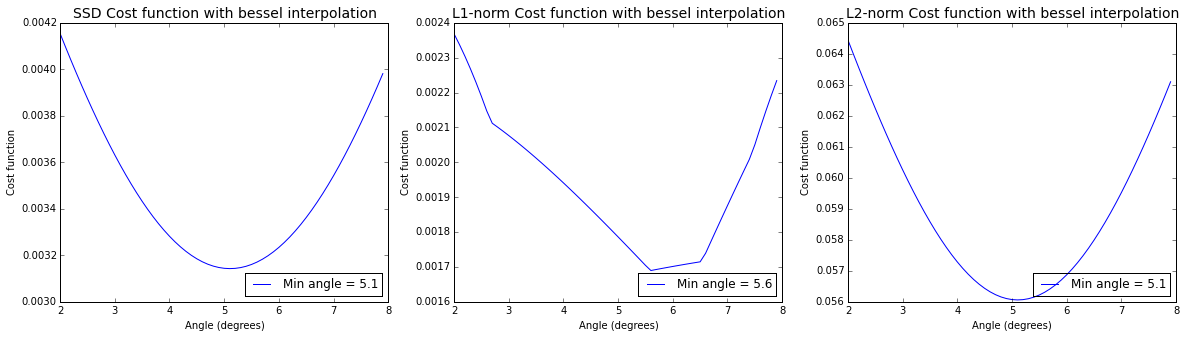

In [7]:
# Cost function from Bessel Rotation
thetas=np.arange(2,8,0.1)
# With circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
rot_cost_func(list_6_4mm[0], list_6_4mm[3], thetas, cf_ssd, 'SSD',ax[0], 'bessel', True)
rot_cost_func(list_6_4mm[0], list_6_4mm[3], thetas, cf_L1, 'L1-norm',ax[1], 'bessel', True)
rot_cost_func(list_6_4mm[0], list_6_4mm[3], thetas, cf_L2, 'L2-norm',ax[2], 'bessel', True)
plt.show()
plt.close(fig)

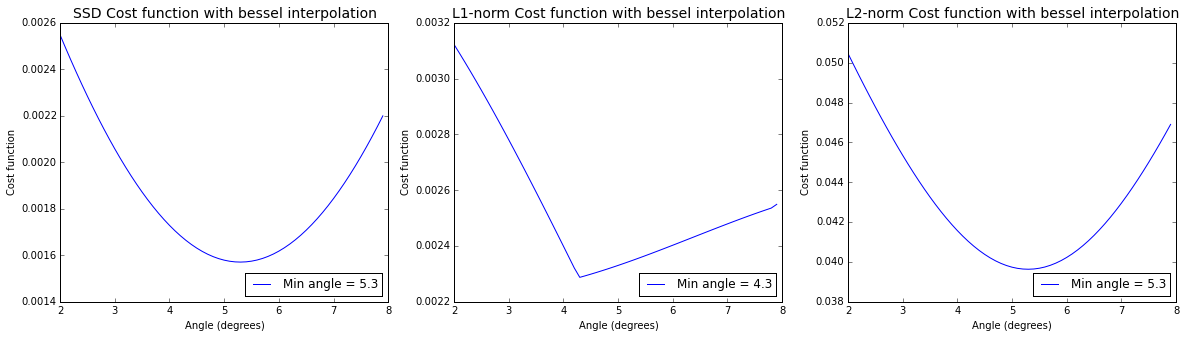

In [8]:
# Cost function from Bessel Rotation
thetas=np.arange(2,8,0.1)
# With circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
rot_cost_func(list_8mm[0], list_8mm[3], thetas, cf_ssd, 'SSD',ax[0], 'bessel', True)
rot_cost_func(list_8mm[0], list_8mm[3], thetas, cf_L1, 'L1-norm',ax[1], 'bessel', True)
rot_cost_func(list_8mm[0], list_8mm[3], thetas, cf_L2, 'L2-norm',ax[2], 'bessel', True)
plt.show()
plt.close(fig)

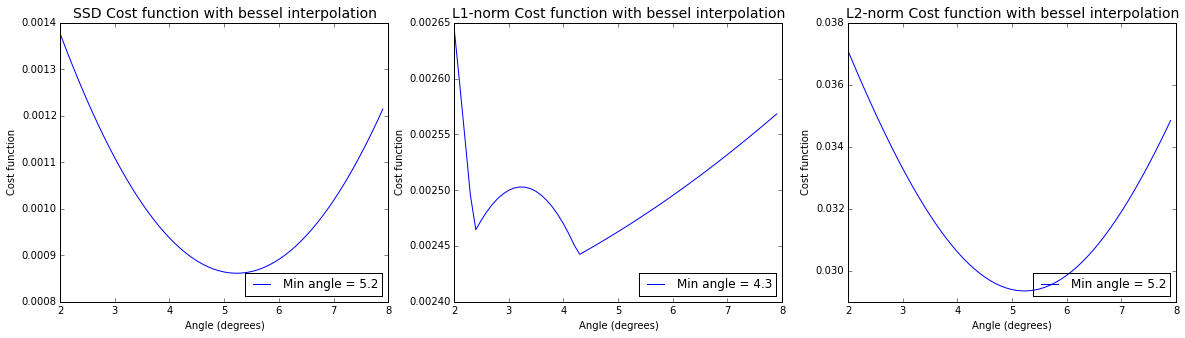

In [9]:
# Cost function from Bessel Rotation
thetas=np.arange(2,8,0.1)
# With circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
rot_cost_func(list_10mm[0], list_10mm[3], thetas, cf_ssd, 'SSD',ax[0], 'bessel', True)
rot_cost_func(list_10mm[0], list_10mm[3], thetas, cf_L1, 'L1-norm',ax[1], 'bessel', True)
rot_cost_func(list_10mm[0], list_10mm[3], thetas, cf_L2, 'L2-norm',ax[2], 'bessel', True)
plt.show()
plt.close(fig)

In [7]:
N = 64
vol1 = list_8mm[0].copy()
new_vol1 = np.empty([len(vol1),N,N])
for i in xrange(len(vol1)):
    sub1 = vol1[i,:,:]
    rot1 = bessel_rotate_halton(sub1, 0, N, True)
    new_vol1[i,:,:] = rot1

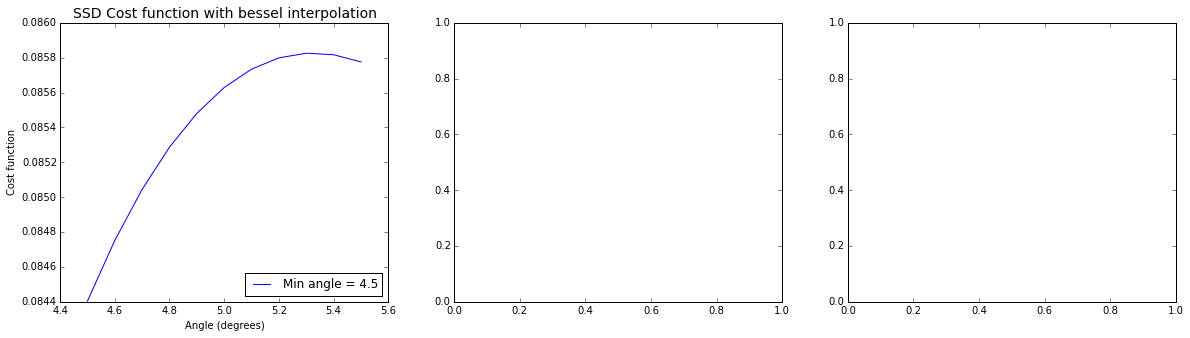

In [13]:
N = 64
# Cost function from Bessel Rotation
thetas=np.arange(4.5,5.6,0.1)
# With circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
rot_halton_cost_func(new_vol1, list_8mm[3], N, thetas, cf_ssd, 'SSD',ax[0], 'bessel', True)
#rot_halton_cost_func(list_8mm[0], list_8mm[3], N, thetas, cf_L1, 'L1-norm',ax[1], 'bessel', True)
#rot_halton_cost_func(list_8mm[0], list_8mm[3], N, thetas, cf_L2, 'L2-norm',ax[2], 'bessel', True)
plt.show()
plt.close(fig)